In [1]:
import torch
from torch import nn, optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
args = {
    'batch_size': 50,
    'lr': 1e-3,
    'weight_decay': 5e-4,
    'num_epochs': 10,
}

In [3]:
data_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

# train_set = datasets.CIFAR10('./', train=True, transform=transforms.ToTensor(), download=True)
train_set = datasets.CIFAR10('./', train=True, transform=transforms.ToTensor(), download=False)

test_set = datasets.CIFAR10('./', train=False, transform=transforms.ToTensor(), download=False)

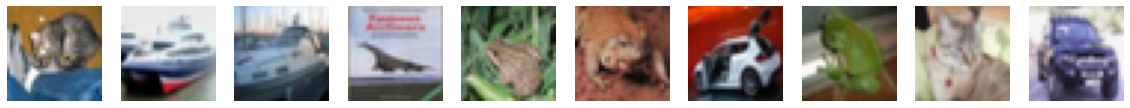

In [4]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    data, label = test_set[i]
    axs[i].imshow(data.permute(1, 2, 0))
    axs[i].axis('off')

In [5]:
train_loader = DataLoader(train_set, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_set, batch_size=args['batch_size'], shuffle=True)

In [6]:
net = nn.Sequential(
    # entrada (b, 3, 32, 32) saida (b, 6, 28, 28)
    nn.Conv2d(3, 6, kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Tanh(), # ativação específica da LeNet
    # entrada (b, 3, 28, 28) saida (b, 6, 14, 14)
    nn.AvgPool2d(kernel_size=2), # pooling específico da LeNet
    
    
    # entrada (b, 6, 14, 14) saida (b, 16, 10, 10)
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Tanh(), # ativação específica da LeNet
    # entrada (b, 16, 10, 10) saida (b, 16, 5, 5)
    nn.AvgPool2d(kernel_size=2), # pooling específico da LeNet
    
    
    # entrada (b, 16, 5, 5) saida (b, 120, 1, 1)
    nn.Conv2d(16, 120, kernel_size=5),
    nn.BatchNorm2d(120),
    nn.Tanh(), # ativação específica da LeNet
    nn.Flatten(),
    
    # entrada (b, N=120*1*1) saida (b, 84)
    nn.Linear(120, 84),
    nn.Tanh(),
    
    # entrada (b, 84) saida (b, 10)
    nn.Linear(84, 10)
)

In [7]:
net

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Tanh()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Tanh()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): Tanh()
  (14): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np
import time, os

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [13]:
def train(train_loader, net, epoch):
    
    # training mode
    net.train()
    
    start = time.time()
    
    epoch_loss = []
    pred_list, rotulo_list = [], []
    
    for batch in train_loader:
        dado, rotulo = batch
        
        # forward
        ypred = net(dado)
        loss = criterion(ypred, rotulo)
        epoch_loss.append(loss.cpu().data)
        
        _, pred = torch.max(ypred, axis=1)
        pred_list.append(pred.cpu().numpy())
        rotulo_list.append(rotulo.cpu().numpy())
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = np.asarray(epoch_loss)
    pred_list = np.asarray(pred_list).ravel()
    rotulo_list = np.asarray(rotulo_list).ravel()
    
    acc = accuracy_score(pred_list, rotulo_list)
    
    end = time.time()
    
    print('============== Train ============== ')
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %2.f, Time: %2.f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
    
    return epoch_loss.mean()

In [14]:
def validate(train_loader, net, epoch):
    
    # evaluation mode
    net.eval()
    
    start = time.time()
    
    epoch_loss = []
    pred_list, rotulo_list = [], []
    
    for batch in train_loader:
        dado, rotulo = batch
        
        # forward
        ypred = net(dado)
        loss = criterion(ypred, rotulo)
        epoch_loss.append(loss.cpu().data)
        
        _, pred = torch.max(ypred, axis=1)
        pred_list.append(pred.cpu().numpy())
        rotulo_list.append(rotulo.cpu().numpy())
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = np.asarray(epoch_loss)
    pred_list = np.asarray(pred_list).ravel()
    rotulo_list = np.asarray(rotulo_list).ravel()
    
    acc = accuracy_score(pred_list, rotulo_list)
    
    end = time.time()
    
    print('============== Validate ============== ')
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %2.f, Time: %2.f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
    
    return epoch_loss.mean()

In [15]:
train_losses, test_losses = [], []

for epoch in range(args['num_epochs']):
    
    # train
    train_losses.append(train(train_loader, net, epoch))
    
    # validate
    test_losses.append(validate(test_loader, net, epoch))

============== Train ============== 
Epoch 0, Loss: 1.4061 +/- 0.1548, Acc: 50, Time: 39

============== Validate ============== 
Epoch 0, Loss: 1.4077 +/- 0.1561, Acc: 50, Time:  6

============== Train ============== 
Epoch 1, Loss: 1.2995 +/- 0.1495, Acc: 54, Time: 38

============== Validate ============== 
Epoch 1, Loss: 1.3271 +/- 0.1623, Acc: 52, Time:  6

============== Train ============== 
Epoch 2, Loss: 1.2318 +/- 0.1508, Acc: 56, Time: 42

============== Validate ============== 
Epoch 2, Loss: 1.2798 +/- 0.1720, Acc: 54, Time:  6

============== Train ============== 
Epoch 3, Loss: 1.1820 +/- 0.1526, Acc: 58, Time: 36

============== Validate ============== 
Epoch 3, Loss: 1.2216 +/- 0.1626, Acc: 57, Time:  6

============== Train ============== 
Epoch 4, Loss: 1.1291 +/- 0.1514, Acc: 60, Time: 32

============== Validate ============== 
Epoch 4, Loss: 1.1947 +/- 0.1634, Acc: 57, Time:  6

============== Train ============== 
Epoch 5, Loss: 1.0928 +/- 0.1528, Acc: 61, Time:

Text(0.5, 0, 'Epochs')

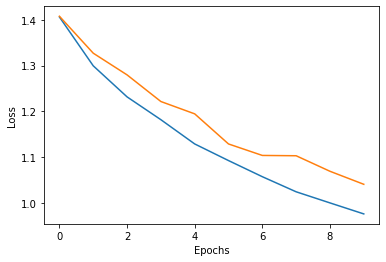

In [16]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')